#### Software package name
pyBlockSeis - Block Choice Seismic Analysis in Python

1. Input data: time series, delta
2. Input parameters
3. Functions
  - compute continuous wavelet transform (CWT)
  - apply a block bandpass
  - calculate noise model and threshold function
  - apply SNR detection method
  - apply hard thresholding to the noise (noise removal)
  - apply soft thresholding to the noise (noise removal)
  - apply hard thresholding to the signal (signal removal)
  - apply soft thresholding to the signal (signal removal)
  - compute the inverse CWT
4. Example of computation in parallel https://deepgraph.readthedocs.io/en/latest/tutorials/pairwise_correlations.html

### Acknowledgements
- Python adpation of the Matlab software Block Choice Seismic Analysis (BCseis, version 1.1) by Charles A. Langston and S. Mostafa Mousavi.
- Forward and inverse CWTs functions based on the Synchrosqueezing Toolbox V1.21 by Eugene Brevdo and Gaurav Thakur.  (https://github.com/ebrevdo/synchrosqueezing).

In [1]:
import sys
sys.path.append("src")

import pyblockseis as bcs
from obspy.core import read
import matplotlib.pyplot as plt

In [2]:
sacfile = "/Users/chiang4/Work/NNSA/LYNM/denoiser/bc_v1.1/data/5014.YW.0.sp0011.DPZ"
st = read(sacfile)
param = bcs.Parameter()
block = bcs.Block(choice=param,data=st)
block.batch_process()

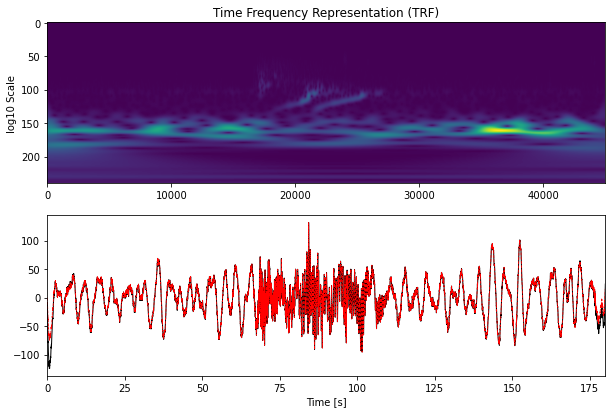

In [5]:
# Plot the wavelet
fig = plt.figure(figsize=(10,6.5))
ax1 = fig.add_subplot(2,1,1)
ax1.imshow(abs(block.cwt[0]), aspect = 'auto') # need to fix x-axis to time
ax1.set_ylabel("log10 Scale")
ax1.set_title("Time Frequency Representation (TRF)")

ax2 = fig.add_subplot(2,1,2)
trace = block.data[0]
ax2.plot(trace.times(), trace.data, color="black", linewidth=1)
ax2.plot(trace.times(), block.icwt[0], "r--", linewidth=0.8)
ax2.set_xlim([0,max(st[0].times())])
ax2.set_xlabel("Time [s]")
plt.show()